In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs import encode_float_filename, decode_float_filename

In [25]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [26]:
dbParams = 0.01
direction = "forward"
mode = "adaptive"
alpha = 0.5

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
thumbUnit = datasetConverter.getDataUnit('thumb_fr')
#thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Forward: Compression rate:0.1924817665542391
========== index ============
Forward: Compression rate:0.20747210931419183
========== middle ============
Forward: Compression rate:0.21060470658325886


================== lenWindow = 20 =================
Train size: 52033, Test size: 52034
(51993, 20, 3)
(51993, 1, 3)
Train size: 52033, Test size: 52034


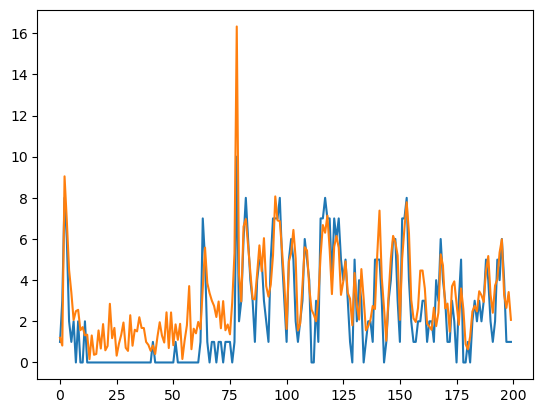

================== lenWindow = 30 =================
Train size: 52033, Test size: 52034
(51973, 30, 3)
(51973, 1, 3)
Train size: 52033, Test size: 52034


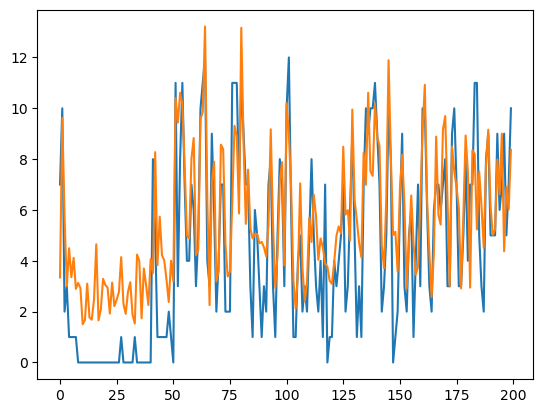

In [27]:
for lenWindow in [20, 30]:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = True

    paramsCA = {}
    paramsCA['lenSource'] = lenWindow
    paramsCA['lenTarget'] = lenWindow
    paramsCA['trainRatio'] = 0.5
    paramsCA['dataAugment'] = trainDataAugment
    paramsCA['smoothFc'] = 1.5
    paramsCA['smoothOrder'] = 3

    #============= Training =============
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsCA, verbose=verbose)
    (sources, _, lastTranmittedContext, _, _, _, _) = trainData
    print(sources.shape)
    print(lastTranmittedContext.shape)
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=False)

    #============= Evaluatation =============
    trafficModelCA, _ = createModelCA(modleParametersCA)
    trafficModelCA.load_state_dict(bestWeightsCA)
    paramsValid = paramsCA.copy()
    paramsValid['dataAugment'] = False
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsValid, verbose=verbose)
    resultsTrain = evaluateModelCA(trafficModelCA, trainData)
    resultsTest = evaluateModelCA(trafficModelCA, testData)

    #print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

    plt.plot(resultsTest['trafficTarget_actual'][0:200])
    plt.plot(resultsTest['trafficTarget_predicted'][0:200])
    plt.show()

    #============= Save Results =============
    dbpString = encode_float_filename(dbParams)
    with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
        pickle.dump(resultsTrain, file)
    with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
        pickle.dump(resultsTest, file)
    with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
        pickle.dump(modleParametersCA, file)
    torch.save(bestWeightsCA, f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth")